In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import copy
from matplotlib import rc
from IPython import display
import random
%matplotlib inline

In [2]:
### PARAMETERS ###

epochs = 1000            ### Number of cycles
world_size = 200        ### Linear dimensions of the (squared) world
group_size = 5         ### Linear dimensions of the (suqared) community

IsWorldFuzzy = True    ### "Fuzzy" world means that cells have a random chance of switching
p_fuzzy = 1.0/world_size/world_size     ### Note that approx. P(1 switch) = world_size*world_size*p_fuzzy
p_fuzzy = 0.0          ### Complete-information game
                       ### If world_size ~ 100, p_fuzzy should be ~ 0.01 ~ to get 100 events (over 10 thousand squares)

alive = 1              ### Def. 1 alive and 0 dead 
dead = 0               ###

In [3]:
### Function to generate a grid with random 1 and 0
def init_grid(size): 
    return np.random.choice([0,1], size*size, p=[0.8, 0.2]).reshape(size, size) 

In [4]:
### Generate world and group at random
world = init_grid(world_size)
group = init_grid(group_size)

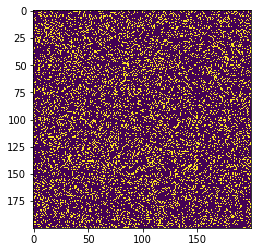

In [5]:
### PLOT INITIAL STATE
plt.imshow(world)
plt.show()

In [6]:
## FUNCTIONS TO PASS FROM SPARSE TO MATRIX REPRESENTATION AND VICE VERSA
### np.argwhere(matrix) returns an array with the coordinates of the vaues that are "1" on the matrix
### The rest is nothing but unexciting python tricks

## TAKE GRID (0 and 1) AS INPUT, RETURN LIST (of coordinates)
def grid_to_list(grid):
    population = np.argwhere(grid).tolist() 
    return population

def grid_to_set(grid):
    population = np.argwhere(grid).tolist()
    population = tuple(map(tuple, population))
    population = set(population)
    return population

## TAKE LIST (of coordinates) AS INPUT, RETURN GRID (of 0 and 1)
def list_to_grid(population, world_size):
    new_grid = np.zeros((world_size, world_size))
    if not population:
        return new_grid
    else:
        row_indices = population[:,0]
        col_indices = population[:,1]
        new_grid[row_indices,col_indices] = 1
        return new_grid    
## TAKE SET (of coordinates) AS INPUT, RETURN GRID (of 0 and 1)
def set_to_grid(population, world_size):
    new_grid = np.zeros((world_size, world_size))
    population = list(population)
    ### BUGFIX v0.1: before it would return an error if the list was empty
    if not population:  
        return new_grid
    else:
        population = np.array(population, dtype = int)
        row_indices = population[:,0]
        col_indices = population[:,1]
        new_grid[row_indices,col_indices] = 1
        return new_grid

In [7]:
### TAKE STARTING WORLD, TRANSFORM INTO LIST OF COORDINATES OF ALIVE CELLS
alive_cells = grid_to_set(world)

In [8]:
### BELOW:
# functions that are the core of the running algorithm
# get_neighbours generates the coordinates of the 8 neighbours of a cell
# apply_rules reads the list of alive cells and decides which lives and which dies
# fuzzy_rules introduces some random chance of a cell switching from 0 to 1 and vice versa
# time_step uses everything else to advance the world of one time step (surprisingly)

In [9]:
## Receive in input the coords of an alive cell
## returns the coords of its neighbors
## uses periodic boundary conditions
def get_neighbours(element, world_size):
    l = []
    l.append( ( (element[0]-1)%world_size, (element[1]  )%world_size ) )
    l.append( ( (element[0]-1)%world_size, (element[1]+1)%world_size ) )
    l.append( ( (element[0]-1)%world_size, (element[1]-1)%world_size ) )
    l.append( ( (element[0]  )%world_size, (element[1]+1)%world_size ) )
    l.append( ( (element[0]  )%world_size, (element[1]-1)%world_size ) )
    l.append( ( (element[0]+1)%world_size, (element[1]+1)%world_size ) )
    l.append( ( (element[0]+1)%world_size, (element[1]-1)%world_size ) )
    l.append( ( (element[0]+1)%world_size, (element[1]  )%world_size ) )
    return l

In [10]:
## SET OF RULES ON SPARSE SET
def apply_rules(alive_cells, world_size):
    counter = {}
    for cell in alive_cells:
        if cell not in counter: ## You don't want to look twice at the same cell
            counter[cell] = 0   ## Initialize counter for alive cells
        neighbours = get_neighbours(cell, world_size) ## Obtain a LIST containing the coordinates of neighbours
        for n in neighbours:
            if n not in counter: ## Cells not in the counter are currently dead
                counter[n] = 1   ## Initialize them with 1 (the current neighbour)
            else:                ## Cells already in the counter are alive
                counter[n] += 1  ## Increment their counter by one
    for c in counter:            ## Now look at the newly created list and apply rules
        if (counter[c] < 2 or counter[c] > 3):
            alive_cells.discard(c)
        if (counter[c] == 3):
            alive_cells.add(c)   ## Add or discard cells according to rules
    return  

In [11]:
## FUZZINESS IN THE WORLD
def fuzzy_rules(alive_cells, world_size, p_fuzzy):
    world = set_to_grid(alive_cells, world_size)
    fuzzy_world = np.zeros((world_size,world_size))
    fuzzy_mask = np.random.rand(world_size,world_size) < p_fuzzy
    fuzzy_events = sum(sum(fuzzy_mask))
    if fuzzy_events != 0:
        print("There were ", fuzzy_events, " fuzzy events today!")
    fuzzy_world[fuzzy_mask] = np.ones((world_size,world_size))[fuzzy_mask] + world[fuzzy_mask]
    fuzzy_world[~fuzzy_mask] = world[~fuzzy_mask]
    fuzzy_world = np.mod(fuzzy_world,2)
    alive_cells = grid_to_set(fuzzy_world)
    return alive_cells

In [12]:
## FUNCTION WHICH MAKES THE TIME STEP
def time_step(alive_cells, world_size, IsWorldFuzzy, p_fuzzy):
    start = time.time()
    old_world = set_to_grid(alive_cells, world_size)
    apply_rules(alive_cells, world_size)
    if IsWorldFuzzy:
        alive_cells = fuzzy_rules(alive_cells, world_size, p_fuzzy)
    next_world = set_to_grid(alive_cells, world_size)
    finish = time.time()
    duration = finish - start
    print("Step peformed in ", duration, " seconds")
    return next_world

KeyboardInterrupt: 

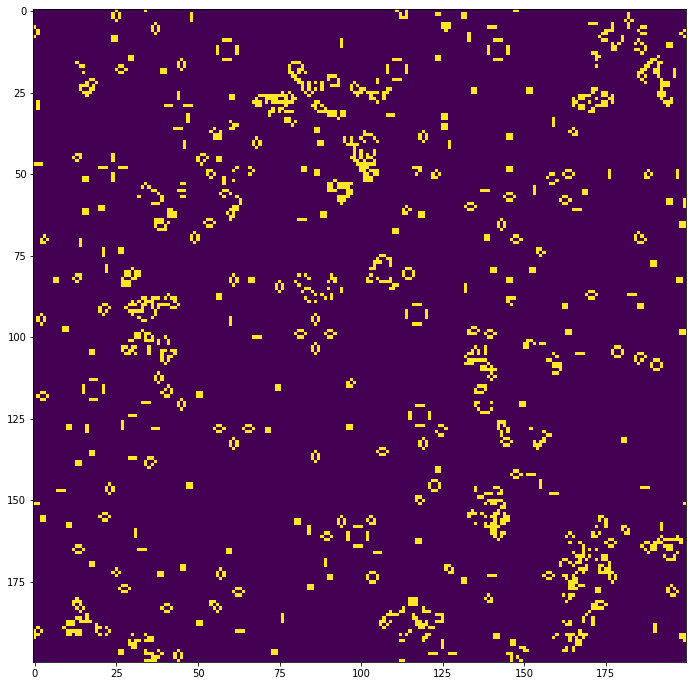

In [13]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(14, 12))
fig.canvas.draw()
img = ax.imshow(world, interpolation='none') 
for i in range(epochs):
    new_world = time_step(alive_cells, world_size, IsWorldFuzzy, p_fuzzy)
    if (i%2)==0:
        old_world = new_world
        if (i%(int(epochs/100))==0):
            print(i/epochs*100, "% of epochs done")
    else:
        if np.array_equal(old_world, new_world):
            print("The world is stuck onto a loop. Exit and restart")
            break
    alive_cells = grid_to_set(new_world)
    img.set_data(new_world)
    display.clear_output(wait=True)
    display.display(fig)
    time.sleep(0.000001)